# IMO - Zadanie 2

Autorzy: Joanna Cicha, Przemysław Łabuń, Maciej Mak

---

Imports:

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import itertools
import time
import multiprocessing as mp
from copy import deepcopy
# plt.rc('figure', dpi=110, figsize=(9, 5))

Scoring functions:

In [37]:
# def cycle_score(cities, path):
#     cycle = path + [path[0]]
#     return sum(cities[cycle[i], cycle[i+1]] for i in range(len(cycle) - 1))

def score(cities, paths):
    cycle_1 = paths[0] + [paths[0][0]]
    cycle_2 = paths[1] + [paths[1][0]]
    score_1=sum(cities[cycle_1[i], cycle_1[i+1]] for i in range(len(cycle_1) - 1))
    score_2=sum(cities[cycle_2[i], cycle_2[i+1]] for i in range(len(cycle_2) - 1))

    return score_1+score_2

def delta_insert(cities, path, i, city):
    a, b = path[i - 1], path[i]
    return cities[a, city] + cities[city, b] - cities[a, b]



Replacing elements for local search (two cycles and one cycle):

In [38]:
# Score difference after replacing element "i" of path with chosen city
def delta_replace_vertex(cities, path, i, city):
    path_len = len(path)
    a, b, c = path[(i - 1)%path_len], path[i], path[(i+1)%path_len]
    return cities[a, city] + cities[city, c] - cities[a, b] - cities[b, c]

# Score difference after exchanging 2 vertices of 2 different paths on indices i and j
def delta_replace_vertices_outside(cities, paths, i, j):
    return delta_replace_vertex(cities, paths[0], i, paths[1][j]) + delta_replace_vertex(cities, paths[1], j, paths[0][i])

# Score difference after exchanging 2 vertices of the same path on indices i and j
def delta_replace_vertices_inside(cities, path, i, j):
    path_len = len(path)
    a, b, c = path[(i - 1)%path_len], path[i], path[(i+1)%path_len]
    d, e, f = path[(j-1)%path_len], path[j], path[(j+1)%path_len]
    if j-i == 1:
        return cities[a,e]+cities[b,f]-cities[a,b]-cities[e,f]
    elif (i, j) == (0, len(path)-1):
        return cities[e, c] + cities[d, b] - cities[b, c] - cities[d, e]
    else:
        return cities[a,e] + cities[e,c] + cities[d,b] + cities[b,f] -cities[a,b]-cities[b,c]-cities[d,e] - cities[e,f] 

# Score difference after exchanging 2 elements of the same path on edges between i and j
def delta_replace_edges_inside(cities, path, i, j):
    path_len = len(path)
    if (i, j) == (0, len(path)-1):
        a, b, c, d = path[i], path[(i+1)%path_len], path[(j-1)%path_len], path[j]
    else:
        a, b, c, d = path[(i - 1)%path_len], path[i], path[j], path[(j+1)%path_len]
    return cities[a, c] + cities[b, d] - cities[a, b] - cities[c, d]

# generates indices for testing every pair of two paths
def outside_candidates(paths):
    indices = list(range(len(paths[0]))), list(range(len(paths[1])))
    indices_pairwise = list(itertools.product(*indices))
    return indices_pairwise

# generates combinations of all pairs of one path
def inside_candidates(path):
    combinations = []
    for i in range(len(path)):
        for j in range(i+1, len(path)):
            combinations.append([i, j])
    return combinations

def replace_vertices_outside(paths, i, j):
    temp = paths[0][i]
    paths[0][i] = paths[1][j]
    paths[1][j] = temp

def replace_vertices_inside(path, i, j):
    temp = path[i]
    path[i] = path[j]
    path[j] = temp
    
def replace_edges_inside(path, i, j):
    if (i, j) == (0, len(path)-1):
        temp = path[i]
        path[i] = path[j]
        path[j] = temp     
    path[i:j+1] = reversed(path[i:j+1])
    


Initial solvers:

In [39]:
def regret(args):
    cities, start_idx = args
    n = cities.shape[0]
    unvisited = list(range(n))
    
    # Choose the starting point for the first cycle
    tour1 = [unvisited.pop(start_idx)]
    nearest_to_first_1 = [cities[tour1[0]][j] for j in unvisited]
    tour1.append(unvisited.pop(np.argmin(nearest_to_first_1)))

    # Choose the furthest city from the starting point as the initial point for the second cycle
    start_city_2_idx = np.argmax([cities[tour1[0]][i] for i in unvisited])
    tour2 = [unvisited.pop(start_city_2_idx)]

    nearest_to_first_2 = [cities[tour2[0]][j] for j in unvisited]
    tour2.append(unvisited.pop(np.argmin(nearest_to_first_2)))

    # Add third point to both tours
    nearest_to_tour_1 = [cities[tour1[0]][j] + cities[tour1[1]][j] for j in unvisited]
    tour1.append(unvisited.pop(np.argmin(nearest_to_tour_1)))

    nearest_to_tour_2 = [cities[tour2[0]][j] + cities[tour2[1]][j] for j in unvisited]
    tour2.append(unvisited.pop(np.argmin(nearest_to_tour_2)))

    # Start adding points that are best fit for the graph
    while len(unvisited) > 0:  # Add when the loop ends
        for tour in [tour1, tour2]:
            regrets = []
            for city in unvisited:
                distances = [cities[tour[i]][city] + cities[city][tour[i+1]] - cities[tour[i]][tour[i+1]] for i in range(len(tour)-1)]
                distances.append(cities[tour[0]][city] + cities[city][tour[-1]] - cities[tour[-1]][tour[0]])
                distances.sort()
                regret = distances[1] - distances[0]
                regret -= 0.37 * distances[0]
                regrets.append((regret, city))
            regrets.sort(reverse=True)
            best_city = regrets[0][1]
            tour_distances = [cities[tour[i]][tour[i+1]] for i in range(len(tour)-1)]
            best_increase = float('inf')
            best_index = -1
            for i in range(len(tour_distances)):
                increase = cities[best_city][tour[i]] + cities[best_city][tour[i+1]] - tour_distances[i]
                if increase < best_increase:
                    best_increase = increase
                    best_index = i + 1
            tour.insert(best_index, best_city)
            unvisited.remove(best_city)
    return [tour1,tour2]


Steepest (best improvement) local search algorithm:

In [40]:
class Steepest(object):
    def __init__(self, cities):
        self.cities = cities
        self.delta = delta_replace_edges_inside
        self.replace = replace_edges_inside
        self.moves = [self.outside_vertices_trade_best, self.inside_trade_best]
    
    def outside_vertices_trade_best(self, cities, paths):
        candidates = outside_candidates(paths)
        scores = np.array([delta_replace_vertices_outside(cities, paths, i, j) for i, j in candidates])
        best_result_idx = np.argmin(scores)
        if scores[best_result_idx] < 0:
            return replace_vertices_outside, (paths, *candidates[best_result_idx]), scores[best_result_idx]
        return None, None, scores[best_result_idx]
            
    def inside_trade_best(self, cities, paths):
        combinations = inside_candidates(paths[0]), inside_candidates(paths[1])
        scores = np.array([[self.delta(cities, paths[idx], i, j) for i, j in combinations[idx]] for idx in range(len(paths))])
        best_path_idx, best_combination = np.unravel_index(np.argmin(scores), scores.shape)
        best_score = scores[best_path_idx, best_combination]
        if best_score < 0:
            return self.replace, (paths[best_path_idx], *combinations[best_path_idx][best_combination]), best_score
        return None, None, best_score 
    
    def __call__(self, paths):
        paths = deepcopy(paths)
        start = time.time()
        while True:
            replace_funs, args, scores = list(zip(*[move(self.cities, paths) for move in self.moves]))
            best_score_idx = np.argmin(scores)
            if scores[best_score_idx] < 0:
                replace_funs[best_score_idx](*args[best_score_idx])
            else:
                break
        return time.time()-start, paths

    def delta_replace_edges_inside(self, cities, path, i, j):
        path_len = len(path)
        if (i, j) == (0, len(path)-1):
            a, b, c, d = path[i], path[(i+1)%path_len], path[(j-1)%path_len], path[j]
        else:
            a, b, c, d = path[(i - 1)%path_len], path[i], path[j], path[(j+1)%path_len]
        return cities[a, c] + cities[b, d] - cities[a, b] - cities[c, d]

    def generate_all_edge_exchange_moves(self, path):
        moves = []
        path_len = len(path)
        for i in range(path_len):
            for j in range(i + 2, path_len):
                moves.append((i, j))
        return moves

    def local_search_steepest(self, cities, initial_solution):
        current_solution = initial_solution
        current_score = score(cities, current_solution)
        LM = []

        while True:
            new_moves = self.generate_all_edge_exchange_moves(current_solution)
            for move in new_moves:
                i, j = move
                delta_score = self.delta_replace_edges_inside(cities, current_solution, i, j)
                if delta_score < 0:
                    new_solution = current_solution[:]
                    if (i, j) == (0, len(current_solution)-1):
                        new_solution[i], new_solution[(i+1)%len(current_solution)], new_solution[(j-1)%len(current_solution)], new_solution[j] = new_solution[j], new_solution[(j-1)%len(current_solution)], new_solution[(i+1)%len(current_solution)], new_solution[i]
                    else:
                        new_solution[i:j+1] = reversed(new_solution[i:j+1])
                    current_solution = new_solution
                    current_score += delta_score
                    break
            else:
                break

        return current_solution, current_score

In [41]:
def pairwise_distances(points):
    num_points = len(points)
    dist_matrix = np.zeros((num_points, num_points))

    for i in range(num_points):
        for j in range(num_points):
            dist_matrix[i, j] = np.linalg.norm(points[i] - points[j])

    return dist_matrix

In [42]:
def plot_optimized_tours(positions, cycle1, cycle2, method):
    # Ensure the cycles start and end at the same city to form closed loops
    cycle1.append(cycle1[0])
    cycle2.append(cycle2[0])

    # Plot the optimized tours
    plt.figure()
    plt.plot(positions[cycle1, 0], positions[cycle1, 1], linestyle='-', marker='o', color='r', label='Cycle 1')
    plt.plot(positions[cycle2, 0], positions[cycle2, 1], linestyle='-', marker='o', color='b', label='Cycle 2')

    # Add legend and title
    plt.legend()
    plt.title(method)
    plt.show()

In [43]:
def index(xs, e):
    try:
        return xs.index(e)
    except:
        return None
        
def find_node(cycles, a):
    i = index(cycles[0], a)
    if i is not None: return 0, i
    i = index(cycles[1], a)
    if i is not None: return 1, i
    print(cycles)
    assert False, f'City {a} must be in either cycle'
    
def remove_at(xs, sorted_indices):
    for i in reversed(sorted_indices):
        del(xs[i])

def reverse(xs, i, j):
    n = len(xs)
    d = (j - i) % n
    #print(d)
    for k in range(abs(d)//2+1):
        a, b = (i+k)%n, (i+d-k)%n
        #print(a, '<->', b)
        xs[a], xs[b] = xs[b], xs[a]

In [44]:
def insert_move(moves, move):
    delta_x = move[0]
    for i, x in enumerate(moves):
        delta_y = x[0]
        if delta_x < delta_y:
            moves.insert(i, move)
            return
        elif delta_x == delta_y:
            return
    moves.append(move)

def has_edge(cycle, a, b):
    for i in range(len(cycle) - 1):
        x, y = cycle[i], cycle[i+1]
        if (a, b) == (x, y): return +1
        if (a, b) == (y, x): return -1
        
    x, y = cycle[-1], cycle[0]
    if (a, b) == (x, y): return +1
    if (a, b) == (y, x): return -1
    return 0

def any_has_edge(cycles, a, b):
    for i in range(2):
        status = has_edge(cycles[i], a, b)
        if status != 0: return i, status
    return None, 0

def delta_swap_node(D, x1, y1, z1, x2, y2, z2):
    return D[x1,y2] + D[z1,y2] - D[x1,y1] - D[z1,y1] + D[x2,y1] + D[z2,y1] - D[x2,y2] - D[z2,y2]

def make_swap_node(cities, cycles, cyc1, i, cyc2, j):
    C1, C2 = cycles[cyc1], cycles[cyc2]
    D = cities
    n, m = len(C1), len(C2)
    x1, y1, z1 = C1[(i-1)%n], C1[i], C1[(i+1)%n]
    x2, y2, z2 = C2[(j-1)%m], C2[j], C2[(j+1)%m]
    delta = delta_swap_node(cities, x1, y1, z1, x2, y2, z2)
    move = delta, SWAP_NODE, cyc1, cyc2, x1, y1, z1, x2, y2, z2
    return delta, move

def delta_swap_edge(cities, a, b, c, d):
    if a == d or a == b or a == c or b == c or b == d or c == d: return 1e8
    return cities[a, c] + cities[b, d] - cities[a, b] - cities[c, d]

def gen_swap_edge_2(cities, cycle, i, j):
    n = len(cycle)
    nodes = cycle[i], cycle[(i+1)%n], cycle[j], cycle[(j+1)%n]
    return (delta_swap_edge(cities, *nodes), *nodes)

def delta_swap_edge_2(cities, cycle, i, j):
    return gen_swap_edge_2(cities, cycle, i, j)[0]

def gen_swap_edge(n):
    return [(i, (i+d)%n) for i in range(n) for d in range(2, n-1)]

def gen_swap_node(n, m):
    return [(i, j) for i in range(n) for j in range(m)]


def init_moves(cities, cycles):
    moves = []
    for k in range(2):
        cycle = cycles[k]
        n = len(cycle)
        for i, j in gen_swap_edge(n):
            delta, a, b, c, d = gen_swap_edge_2(cities, cycle, i, j)
            if delta < 0: moves.append((delta, SWAP_EDGE, a, b, c, d))
    for i, j in gen_swap_node(len(cycles[0]), len(cycles[1])):
        delta, move = make_swap_node(cities, cycles, 0, i, 1, j)
        if delta < 0: moves.append(move)
    return moves
 
SWAP_EDGE, SWAP_NODE = range(2)
def apply_move(cycles, move):
    kind = move[1]
    if kind == SWAP_EDGE:
        _, _, a, _, c, _ = move
        (c1, i), (c2, j) = find_node(cycles, a), find_node(cycles, c)
        #print('swap edge', c1, i, c2, j, move[0])
        #assert c1 == c2, 'Cannot swap edges between cycles'
        cycle = cycles[c1]
        n = len(cycle)
        reverse(cycle, (i+1)%n, j)
    elif kind == SWAP_NODE:
        _, _, c1, c2, _, a, _, _, b, _ = move
        i, j = cycles[c1].index(a), cycles[c2].index(b)
        #print('swap node', c1, i, c2, j, move[0])
        #assert c1 != c2, 'Cannot swap nodes in the same cycle'
        cycles[c1][i], cycles[c2][j] = cycles[c2][j], cycles[c1][i]
    else:
        assert False, 'Invalid move type'

In [45]:
class SearchCandidates:
    def __init__(self, cities):
        self.cities = cities
    
    def __call__(self, cycles, k=10):
        N = len(self.cities)
        cycles = deepcopy(cycles)
        start = time.time()
        closest = np.argpartition(self.cities, k+1, axis=1)[:,:k+1]
        
        while True:
            best_move, best_delta = None, 0
            for a in range(N):
                for b in closest[a]:
                    if a == b: continue
                    (c1, i), (c2, j) = find_node(cycles, a), find_node(cycles, b)
                    move, delta = None, None
                    if c1 == c2:
                        cycle = cycles[c1]
                        n = len(cycle)
                        a, b, c, d = a, cycle[(i+1)%n], b, cycle[(j+1)%n]
                        delta = delta_swap_edge(self.cities, a, b, c, d)
                        move = delta, SWAP_EDGE, a, b, c, d
                    else:
                        delta, move = make_swap_node(self.cities, cycles, c1, i, c2, j)
                    if delta < best_delta:
                        best_delta, best_move = delta, move
                        
            if best_move is None:
                break
                
            apply_move(cycles, best_move)
                
        return time.time() - start, cycles

In [46]:
class SearchMemory:
    def __init__(self, cities):
        self.cities = cities
    
    def next_moves(self, cycles, move):
        kind = move[1]
        moves = []
        if kind == SWAP_EDGE:
            _, _, a, b, c, d = move
            cycle = cycles[0] if a in cycles[0] else cycles[1]
            n = len(cycle)
            for i, j in gen_swap_edge(n):
                delta, a, b, c, d = gen_swap_edge_2(self.cities, cycle, i, j)
                if delta < 0: moves.append((delta, SWAP_EDGE, a, b, c, d))
                
        elif kind == SWAP_NODE:
            _, _, c1, c2, _, y1, _, _, y2, _ = move
            i, j = cycles[c1].index(y2), cycles[c2].index(y1)
            n, m = len(cycles[c1]), len(cycles[c2])
            for k in range(m):
                delta, move = make_swap_node(self.cities, cycles, c1, i, c2, k)
                if delta < 0: moves.append(move)
            for k in range(n):
                delta, move = make_swap_node(self.cities, cycles, c2, j, c1, k)
                if delta < 0: moves.append(move)
                
        #moves = init_moves(self.cities, cycles)
        return moves
    
    def __call__(self, cycles):
        cycles = deepcopy(cycles)
        start = time.time()
        moves = sorted(init_moves(self.cities, cycles), key=lambda x: x[0])
        #fig, ax = plt.subplots()
        
        while True:
            to_delete = []
            best_move = None
            for k, move in enumerate(moves):
                kind = move[1]
                if kind == SWAP_EDGE:
                    _, _, a, b, c, d = move
                    (c1, s1), (c2, s2) = any_has_edge(cycles, a, b), any_has_edge(cycles, c, d)
                    if c1 != c2 or s1 == 0 or s2 == 0:
                        to_delete.append(k)
                    elif s1 == s2 == +1:
                        to_delete.append(k)
                        best_move = move
                        break
                    elif s1 == s2 == -1:
                        to_delete.append(k)
                        best_move = move[0], SWAP_EDGE, b, a, d, c
                        break
                elif kind == SWAP_NODE:
                    _, _, c1, c2, x1, y1, z1, x2, y2, z2 = move
                    s1 = has_edge(cycles[c1], x1, y1)
                    s2 = has_edge(cycles[c1], y1, z1)
                    s3 = has_edge(cycles[c2], x2, y2)
                    s4 = has_edge(cycles[c2], y2, z2)
                    
                    if c1 == c2 or s1 == 0 or s2 == 0 or s3 == 0 or s4 == 0:
                        to_delete.append(k)
                    elif s1 == s2 and s3 == s4:
                        to_delete.append(k)
                        best_move = move
                        break
                    
            if best_move is None:
                break
                
            remove_at(moves, to_delete)
            apply_move(cycles, best_move)
            
            #plt.cla()
            #plot_solution(coords, cycles)
            #fig.canvas.draw()
            #plt.pause(0.001)
            
            new_moves = self.next_moves(cycles, best_move)
            moves = sorted(list(set(moves).union(set(new_moves))), key=lambda x: x[0])
            #print(len(moves))
            
        return time.time() - start, cycles

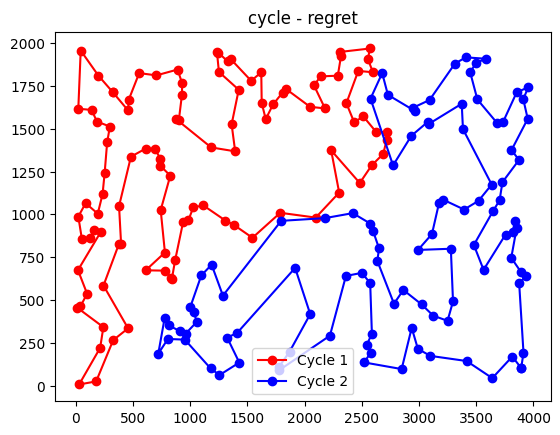

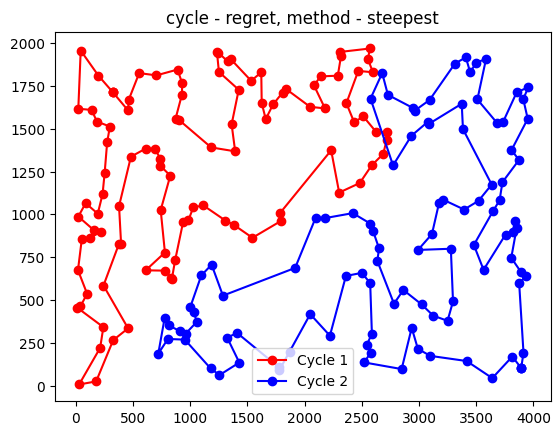

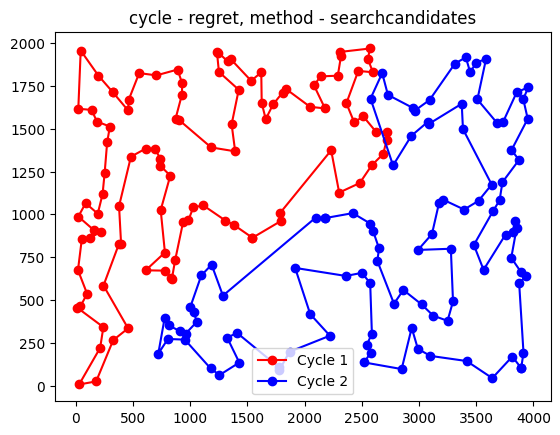

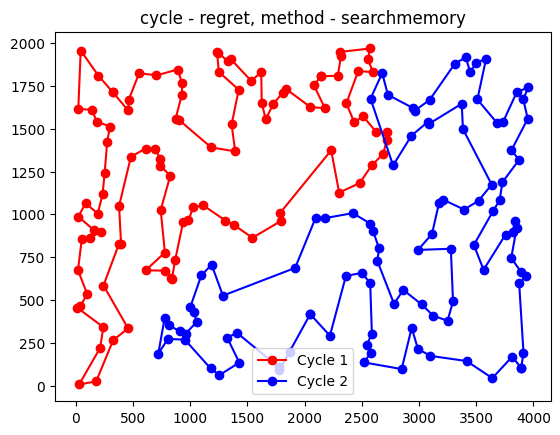

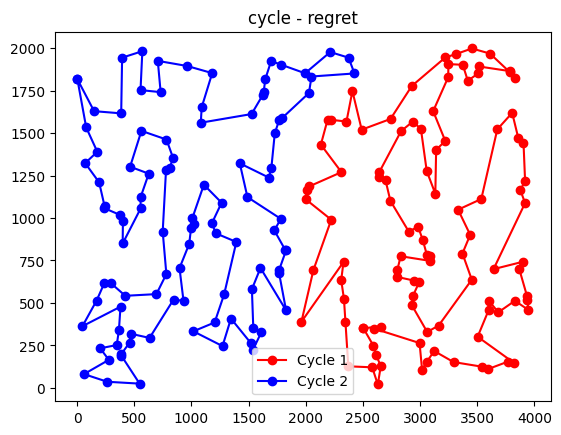

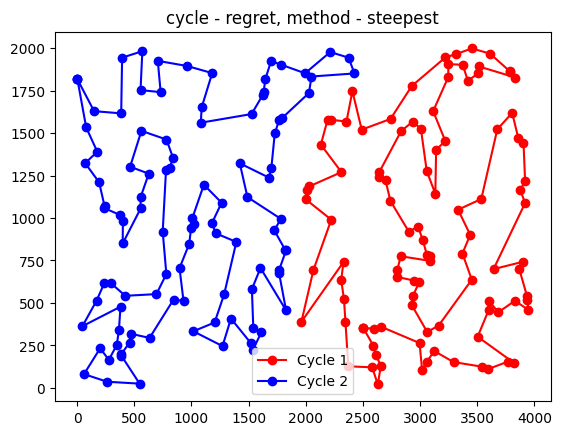

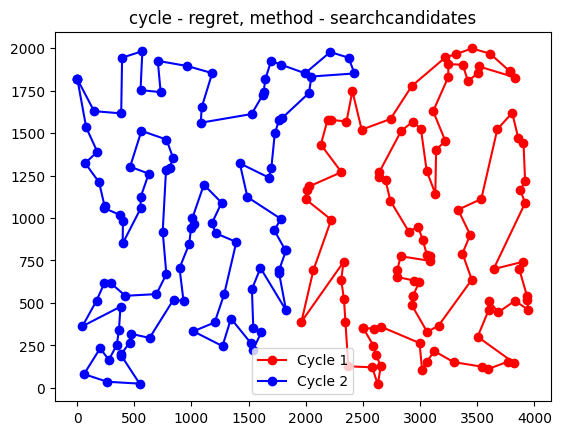

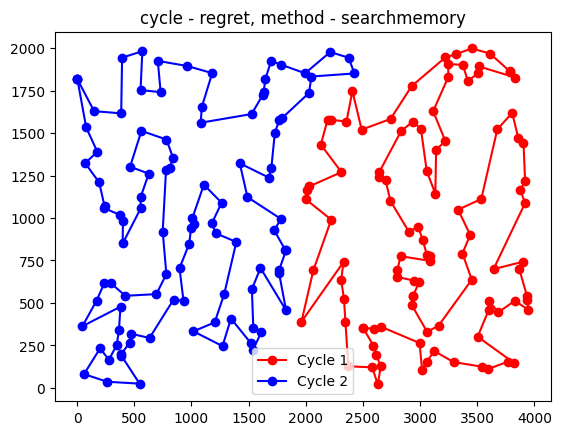

In [47]:
score_results = []
time_results = []
for file in ['kroa.csv','krob.csv']:
    coords = pd.read_csv(file, sep=' ')
    positions=np.array([coords['x'], coords['y']]).T
    cities = np.round(pairwise_distances(np.array(positions)))

    local_variants = [Steepest(cities), SearchCandidates(cities), SearchMemory(cities)]
    # local_variants=[]
    # local_variants = [GreedySearch(cities, "vertices")]
    for solve in [regret]:
        solutions = list(map(solve, [(cities, i) for i in range(100)]))
        scores = [score(cities, x) for x in solutions]
        score_results.append(dict(file=file, function=solve.__name__, search="none", variant="none", min=int(min(scores)), mean=int(np.mean(scores)), max=int(max(scores))))
        best_idx = np.argmin(scores)
        best = solutions[best_idx]
        plot_optimized_tours(positions, *best, f'cycle - {solve.__name__}')
        for local_search in local_variants:
            times, new_solutions = zip(*list(map(local_search, solutions)))
            new_scores = [score(cities, x) for x in new_solutions]
            best = new_solutions[best_idx]
            plot_optimized_tours(positions, *best, f'cycle - {solve.__name__}, method - {(type(local_search).__name__).lower()}')
            score_results.append(dict(file=file, function=solve.__name__, search=type(local_search).__name__, min=int(min(new_scores)), mean=int(np.mean(new_scores)), max=int(max(new_scores))))
            time_results.append(dict(file=file, function=solve.__name__, search=type(local_search).__name__, min=float(min(times)), mean=float(np.mean(times)), max=float(max(times))))
scores = pd.DataFrame(score_results)
times = pd.DataFrame(time_results)

In [48]:
scores

,file,function,search,variant,min,mean,max
0,kroa.csv,regret,none,none,32529,35061,39595
1,kroa.csv,regret,Steepest,NaN,31495,33458,35777
2,kroa.csv,regret,SearchCandidates,NaN,31643,33641,37690
3,kroa.csv,regret,SearchMemory,NaN,31589,33737,36950
4,krob.csv,regret,none,none,32812,36284,38965
5,krob.csv,regret,Steepest,NaN,32503,34476,36851
6,krob.csv,regret,SearchCandidates,NaN,32476,35006,37014
7,krob.csv,regret,SearchMemory,NaN,32503,34744,37076


In [49]:
times

,file,function,search,min,mean,max
0,kroa.csv,regret,Steepest,0.245403,0.716475,1.194625
1,kroa.csv,regret,SearchCandidates,0.101770,0.220245,0.368157
2,kroa.csv,regret,SearchMemory,0.069989,0.244848,0.369726
3,krob.csv,regret,Steepest,0.090860,0.626920,1.375895
4,krob.csv,regret,SearchCandidates,0.037500,0.198490,0.453897
5,krob.csv,regret,SearchMemory,0.069322,0.205695,0.396887
